# Post-processing

Associate the windowed data to the original waveform

In [12]:
import argparse
import ROOT
from ROOT import TFile, TTree
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

parser = argparse.ArgumentParser()
parser.add_argument('--dataFile', type=str, default='../sample/sample_1.root')
parser.add_argument('--datasetFile', type=str, default='dataset_test.txt')
parser.add_argument('--probFile', type=str, default='prob_test.root')
parser.add_argument('--output', type=str, default='counting_test.root')
parser.add_argument('--nsize', type=int, default=-1)
parser.add_argument('--isData', type=bool, default=False)
parser.add_argument('--useD2', type=bool, default=False)
parser.add_argument('--cut', type=float, default=0.95)

#args = parser.parse_args()
args = parser.parse_args([])

filename_data = args.dataFile
filename_dataset = args.datasetFile
filename_prob = args.probFile
filename_output = args.output
nsize = args.nsize
isData = args.isData
useD2 = args.useD2
cut = args.cut

In [2]:
def plot_waveform(wf, amp, time, tag, truth, truth_tag):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlabel('Index')
    ax.set_ylabel('Amplitude')

    wf_x = list(range(len(wf)))
    ax.plot(wf_x, wf)

    if not tag is None:
        amp_pri = [a for i, a in enumerate(amp) if tag[i] == 0] 
        time_pri = [t for i, t in enumerate(time) if tag[i] == 0]
        ax.plot(time_pri, amp_pri, 'o')

        amp_sec = [a for i, a in enumerate(amp) if tag[i] == 1]
        time_sec = [t for i, t in enumerate(time) if tag[i] == 1]
        ax.plot(time_sec, amp_sec, 'o')

        amp_bkg = [a for i, a in enumerate(amp) if tag[i] == 2]
        time_bkg = [a for i, a in enumerate(time) if tag[i] == 2]
        ax.plot(time_bkg, amp_bkg, 'o')

        truth_time_pri = [t for i, t in enumerate(truth) if truth_tag[i] == 0]
        truth_amp_pri = [wf[int(t)] for t in truth_time_pri]
        ax.vlines(truth_time_pri, 0, truth_amp_pri, color='orange')

        truth_time_sec = [t for i, t in enumerate(truth) if truth_tag[i] == 1]
        truth_amp_sec = [wf[int(t)] for t in truth_time_sec]
        ax.vlines(truth_time_sec, 0, truth_amp_sec, color='green')

    if tag is None:
        ax.plot(time, amp, 'o')


    plt.savefig('counting_%d.png' % (plot_waveform.fig_id))
    plot_waveform.fig_id += 1


# initialize the func parameter
plot_waveform.fig_id = 0



In [3]:
def sort_map(this_map):
    sorted_item = sorted(this_map.items())
    return {k:v for k,v in sorted_item}

In [4]:
def match(truth, truth_tag, det):
    det2truth = []
    for i, t_det in enumerate(det):
        this_map = {}
        for j, t_truth in enumerate(truth):
            this_map[abs(t_det - t_truth)] = j
        sorted_map = sort_map(this_map)
        det2truth.append(sorted_map)

    truth2det = []
    for i, t_truth in enumerate(truth):
        this_map = {}
        for j, t_det in enumerate(det):
            this_map[abs(t_det - t_truth)] = j
        sorted_map = sort_map(this_map)
        truth2det.append(sorted_map)


    id = [2 for x in det]

    for i, d2t_map in enumerate(det2truth):
        truth_idx = list(d2t_map.values())[0]

        t2d_map = truth2det[truth_idx]
        det_idx = list(t2d_map.values())[0]

        id[i] = 2
        if i == det_idx:
            id[i] = truth_tag[truth_idx]

    return id

In [5]:
# data file
file_data = TFile(filename_data)
tree = file_data.Get('signal')

sampling_rate = array('d', [-1])
wf = ROOT.std.vector['double'](0)
truth_time = ROOT.std.vector['double'](0)
truth_tag = ROOT.std.vector['int'](0)

tree.SetBranchAddress('sampling_rate', sampling_rate)
tree.SetBranchAddress('wf_i', wf)
if not isData:
    tree.SetBranchAddress('time', truth_time)
    tree.SetBranchAddress('tag', truth_tag)


In [6]:
# dataset file
nleft = 5
nright = 9
ndim = 1

dataset = pd.read_csv(filename_dataset, skipinitialspace=True)

evtno_list = dataset['EvtNo'].values
peak_time_list = dataset['Time']

In [7]:
# prob file
file_prob = TFile(filename_prob)
tree_prob = file_prob.Get('tmva')

prob_ml = array('d', [-1.])
prob_d2 = array('d', [-1.])

tree_prob.SetBranchAddress('prob_rnn', prob_ml)
if useD2:
    tree_prob.SetBranchAddress('prob_d2', prob_d2)

In [8]:
# output file
file_out = TFile(filename_output, 'recreate')
tree_out = TTree('signal', 'signal')

ncount = array('i', [-1])
ncount_pri = array('i', [-1])
ncls = array('i', [-1])
sampling_rate_out = array('d', [-1.])
count_x = ROOT.std.vector['double'](0)
id = ROOT.std.vector['int'](0)
wf_out = ROOT.std.vector['double'](0)

tree_out.Branch('sampling_rate', sampling_rate_out, 'sampling_rate/D')
tree_out.Branch('wf_i', wf_out)
tree_out.Branch('ncount', ncount, 'ncount/I')
tree_out.Branch('count_x', count_x)
if not isData:
    tree_out.Branch('id', id)
    tree_out.Branch('ncount_pri', ncount_pri, 'ncount_pri/I')
    tree_out.Branch('ncls', ncls, 'ncls/I')

In [9]:
n = tree_prob.GetEntries() if nsize < 0 else nsize

detected_time = {}
for i in range(n):
    if i % 10000 == 0:
        print('Processing event %d ...' % i)
    
    tree_prob.GetEntry(i)

    prob = prob_d2[0] if useD2 else prob_ml[0]
    evtno = evtno_list[i]
    peak_time = peak_time_list[i]

    if (prob > cut):
        if not evtno in detected_time:
            detected_time[evtno] = []
        detected_time[evtno].append(peak_time)

#print(detected_time)


Processing event 0 ...
Processing event 10000 ...
Processing event 20000 ...
Processing event 30000 ...
Processing event 40000 ...
Processing event 50000 ...
Processing event 60000 ...
Processing event 70000 ...
Processing event 80000 ...
Processing event 90000 ...
Processing event 100000 ...
Processing event 110000 ...
Processing event 120000 ...
Processing event 130000 ...
Processing event 140000 ...
Processing event 150000 ...
Processing event 160000 ...
Processing event 170000 ...
Processing event 180000 ...
Processing event 190000 ...
Processing event 200000 ...
Processing event 210000 ...
Processing event 220000 ...
Processing event 230000 ...
Processing event 240000 ...
Processing event 250000 ...
Processing event 260000 ...
Processing event 270000 ...
Processing event 280000 ...
Processing event 290000 ...
Processing event 300000 ...
Processing event 310000 ...
Processing event 320000 ...
Processing event 330000 ...
Processing event 340000 ...
Processing event 350000 ...
Proces

Legend in the plots:
- Orange/green lines: primary/secondary truth times
- Orange/green/red points: detected primary/secondary/noise times (with a MC truth matching algorithm)

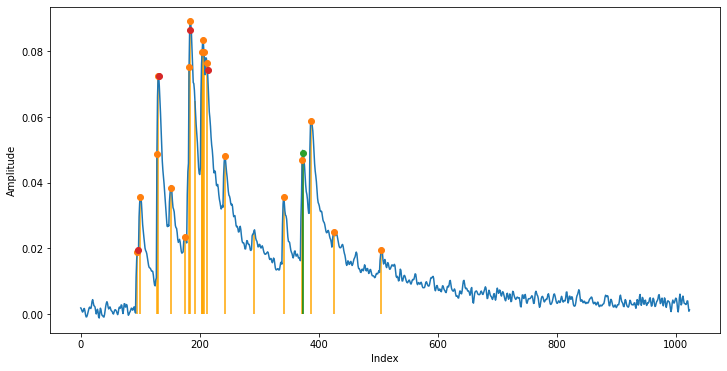

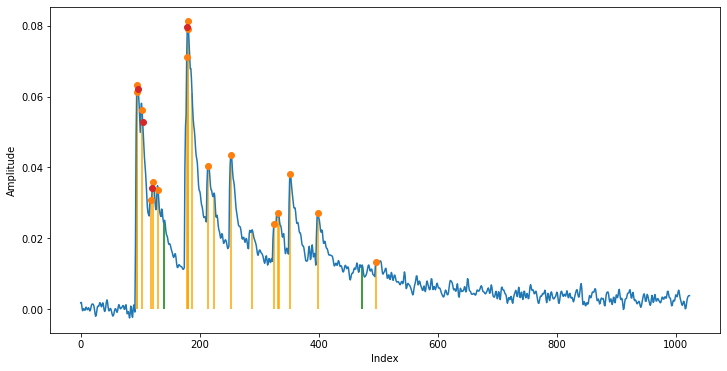

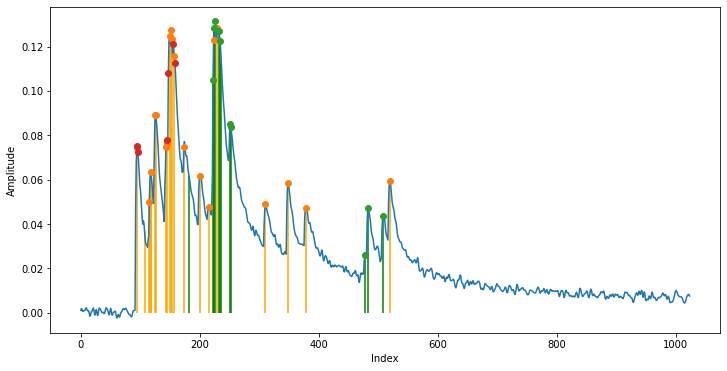

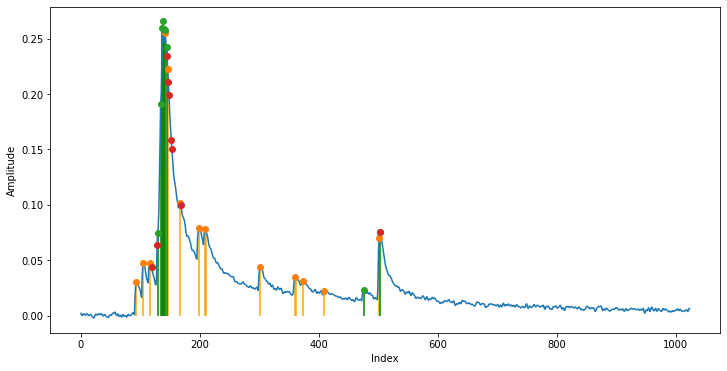

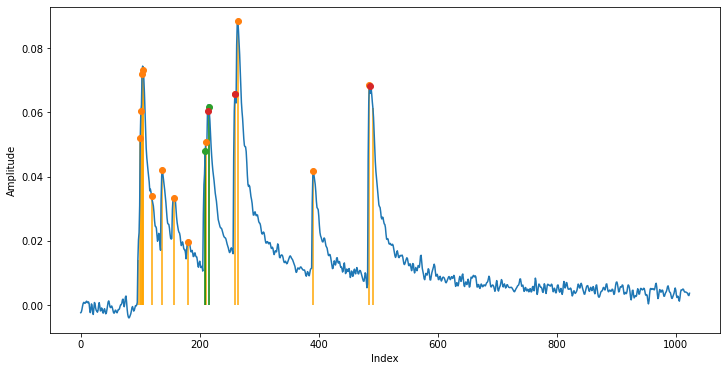

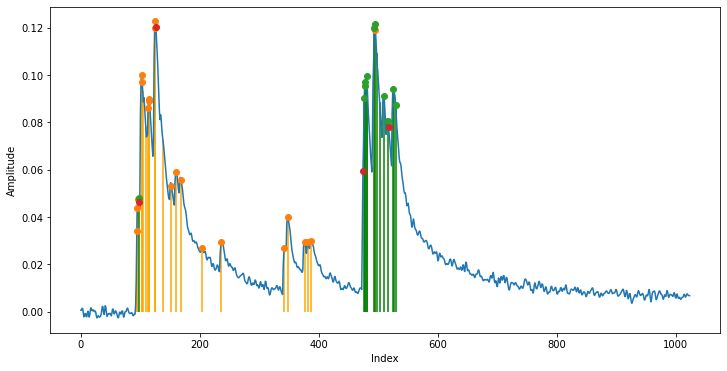

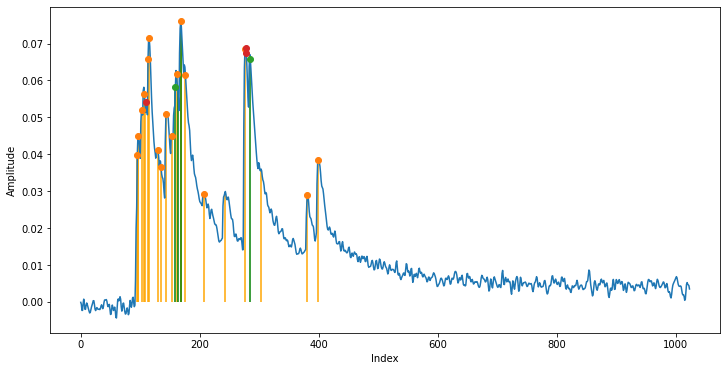

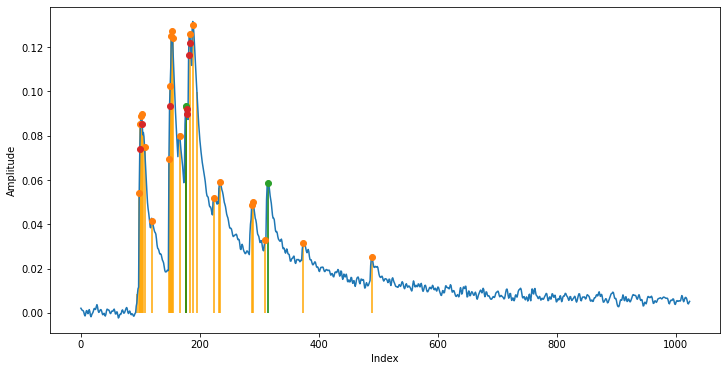

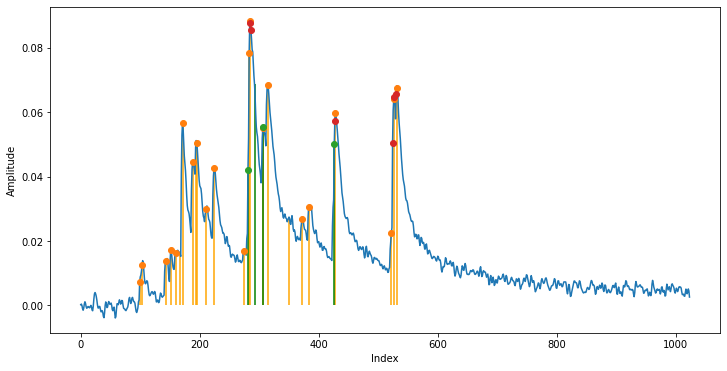

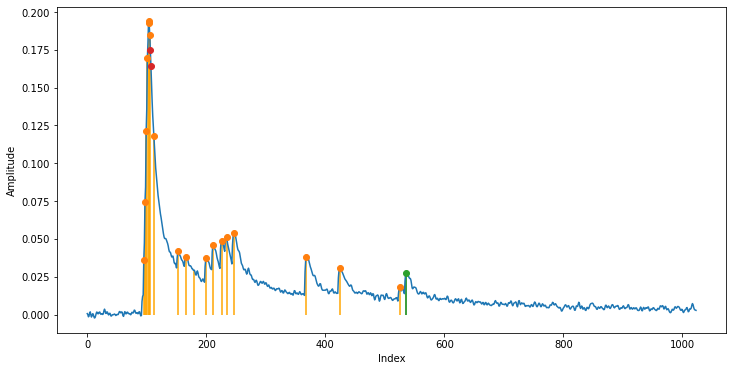

In [10]:
for evtno in detected_time:
    tree.GetEntry(evtno)

    sampling_rate_out[0] = sampling_rate[0]
    vtime = detected_time[evtno]
    vamp = []
    ncount[0] = len(vtime)
    count_x.clear()
    wf_out.clear()
    id.clear()

    for i in range(wf.size()):
        if isData:
            wf[i] = wf[i] * -1.
        wf_out.push_back(wf[i])

    for t in vtime:
        vamp.append(wf[int(t)])
        count_x.push_back(float(t/sampling_rate))

    vtime_truth = []
    vtag_truth = []
    if not isData:
        ncls[0] = 0
        
        for itruth in range(truth_tag.size()):
            if truth_tag[itruth] < 2:
                vtime_truth.append(truth_time[itruth])
                vtag_truth.append(truth_tag[itruth])
            if truth_tag[itruth] == 0:
                ncls[0] = ncls[0] + 1

        id_list = match(vtime_truth, vtag_truth, vtime)
        for _id in id_list:
            id.push_back(_id)
            
        ncount_pri[0] = 0
        for idx in range(id.size()):
            if id[idx] == 0:
                ncount_pri[0] = ncount_pri[0] + 1

    if evtno < 10:
        wf_list = []
        for iwf in range(wf.size()):
            wf_list.append(wf[iwf])

        if not isData:
            plot_waveform(wf_list, vamp, vtime, id_list, vtime_truth, vtag_truth)
        else:
            plot_waveform(wf_list, vamp, vtime, None, None, None)


    tree_out.Fill()

file_out.WriteTObject(tree_out)
file_out.Close()
